# A

Why is VQ-VAE better than VAE?

The distribution of latent variable in VAE is continuous, which is not practical in most use cases in generative modeling. VQ-VAE uses a discrete latent variable, which is more practical. This can result in high quality samples which are not images in between modes. When we want to generate images, we can use a decoder to map the discrete latent variable to a continuous latent variable, and then use the decoder to generate images.

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [2]:
from torch import nn
import torch.nn.functional as F

class FullyConvolutionalEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, embedding_dim, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)
        return x

class FullyConvolutionalDecoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(embedding_dim, 512, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, input_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = F.relu(self.bn2(self.conv2(x))) 
        x = F.relu(self.bn3(self.conv3(x))) 
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.sigmoid(self.conv6(x))
        return x

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.embeddings = nn.Parameter(torch.rand(self.num_embeddings, self.embedding_dim))
        self.codebook_indices = None

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_flat = x.view(-1, self.embedding_dim)

        distances = (torch.sum(x_flat**2, dim=1, keepdim=True) 
                    + torch.sum(self.embeddings**2, dim=1)
                    - 2 * torch.matmul(x_flat, self.embeddings.t()))

        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        self.codebook_indices = encoding_indices
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=x.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embeddings).view(x.shape)

        e_latent_loss = F.mse_loss(quantized.detach(), x)
        q_latent_loss = F.mse_loss(quantized, x.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()
        return loss, quantized.permute(0, 3, 1, 2).contiguous()
    
class VectorQuantizedVAE(nn.Module):
    def __init__(self, input_dim, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.encoder = FullyConvolutionalEncoder(input_dim, embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = FullyConvolutionalDecoder(input_dim, embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized = self.vq(z)
        x_hat = self.decoder(quantized)
        loss = F.binary_cross_entropy(x_hat, x) + loss
        return loss, x_hat, quantized

In [3]:
from tqdm import tqdm

model = VectorQuantizedVAE(1, 3, 2, 0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, train_loader, optimizer, num_epochs=10):
    codebooks = []
    for epoch in range(num_epochs):
        pbar = tqdm(train_loader)
        for i, (img, _) in enumerate(pbar):
            img = img.to(device)
            optimizer.zero_grad()
            loss, _, _ = model(img)
            loss.backward()
            optimizer.step()
            pbar.set_description(f'Epoch: {epoch + 1}, Step: {i + 1}, Loss: {loss.item():.4f}')
            codebooks.append(model.vq.embeddings.detach().cpu().numpy())
    return codebooks
    
codebooks = train(model, train_loader, optimizer, num_epochs=10)

Epoch: 10, Step: 469, Loss: 0.1997: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]


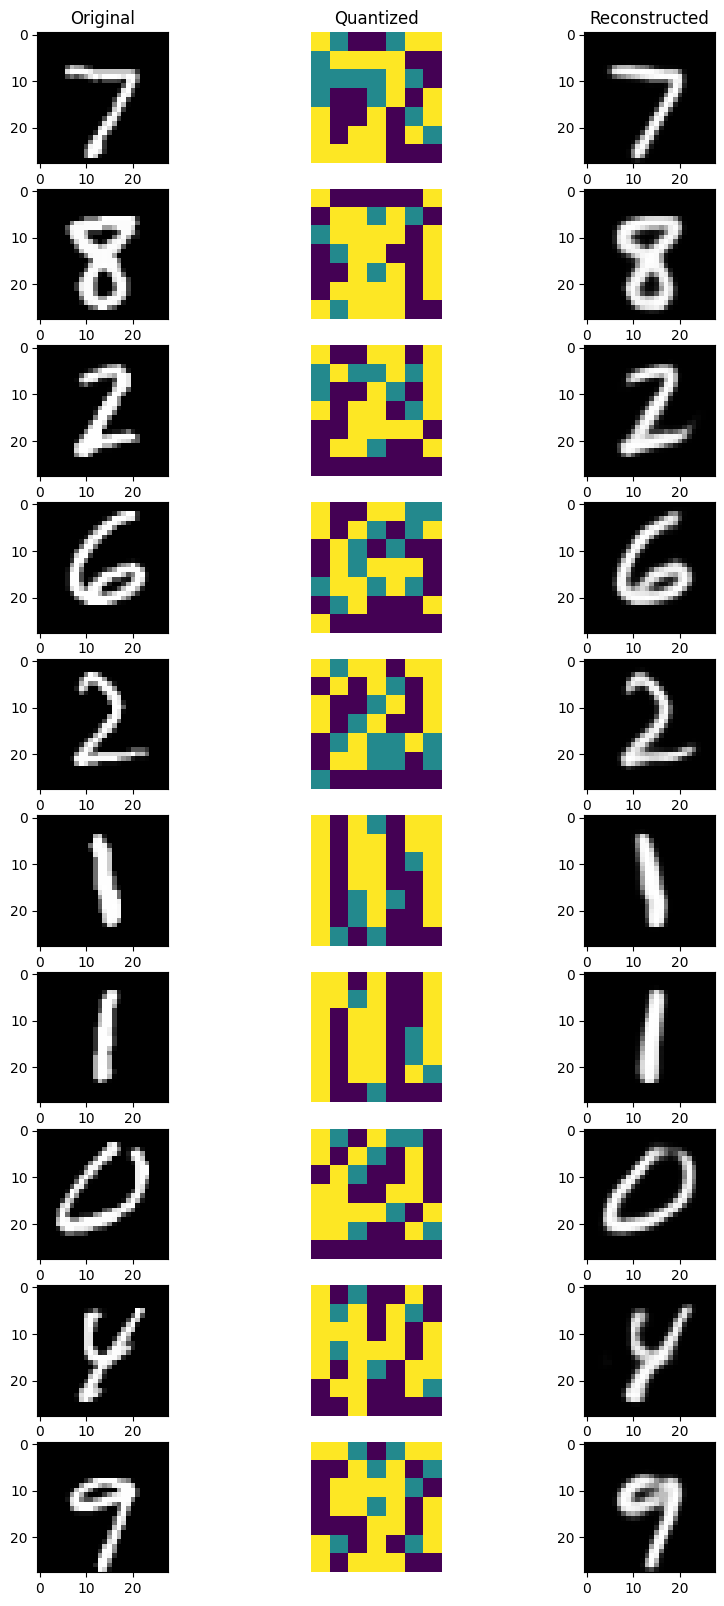

In [5]:
# plot reconstructions
import matplotlib.pyplot as plt

def plot_samples(model, test_loader):
    fig, axs = plt.subplots(10, 3, figsize=(10, 20))
    for i, (img, _) in enumerate(test_loader):
        img = img.to(device)
        _, recon, quantized = model(img)
        quantized = quantized.to('cpu').detach().numpy()
        img = img.to('cpu').detach().numpy()
        recon = recon.to('cpu').detach().numpy()
        axs[i, 0].imshow(img[0][0], cmap='gray')
        if i == 0:
            axs[i, 0].set_title('Original')
        axs[i, 1].imshow(quantized[0][0])
        if i == 0:
            axs[i, 1].set_title('Quantized')
        axs[i, 1].axis('off')
        axs[i, 2].imshow(recon[0][0], cmap='gray')
        if i == 0:
            axs[i, 2].set_title('Reconstructed')
        if i == 9:
            break

plot_samples(model, test_loader)

In [6]:
import imageio
import numpy as np

def save_codebook_animation(codebooks, filename):
    images = []
    for codebook in tqdm(codebooks[::10]):
        fig = plt.figure(figsize=(5, 5))
        plt.plot(codebook[:, 0], codebook[:, 1], 'o')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)
        plt.close()
    imageio.mimsave(filename, images, fps=10)

save_codebook_animation(codebooks, 'codebook_3.gif')

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:14<00:00, 32.57it/s]


In [7]:
class ColoredMNIST(MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data = self.data.unsqueeze(1).float() / 255
        self.targets = self.targets.long()
    
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = img.repeat(3, 1, 1)
        img *= torch.rand(3, 1, 1)
        return img, target

train_dataset = ColoredMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = ColoredMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 469/469 [00:16<00:00, 29.21it/s]


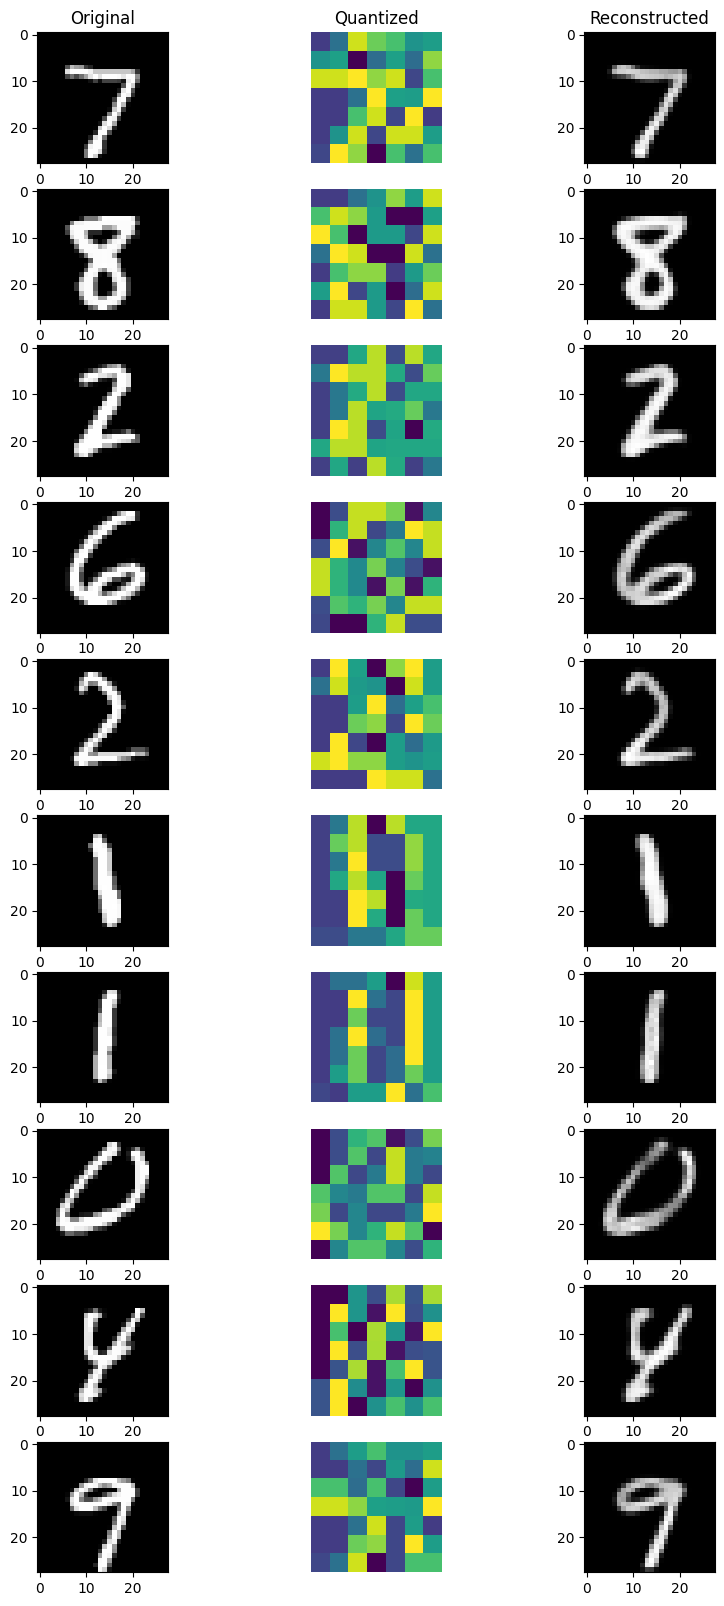

In [8]:
model = VectorQuantizedVAE(3, 15, 2, 0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

codebooks = train(model, train_loader, optimizer, num_epochs=10)
plot_samples(model, test_loader)
save_codebook_animation(codebooks, 'codebook_15.gif')

100%|██████████| 469/469 [00:17<00:00, 27.44it/s]


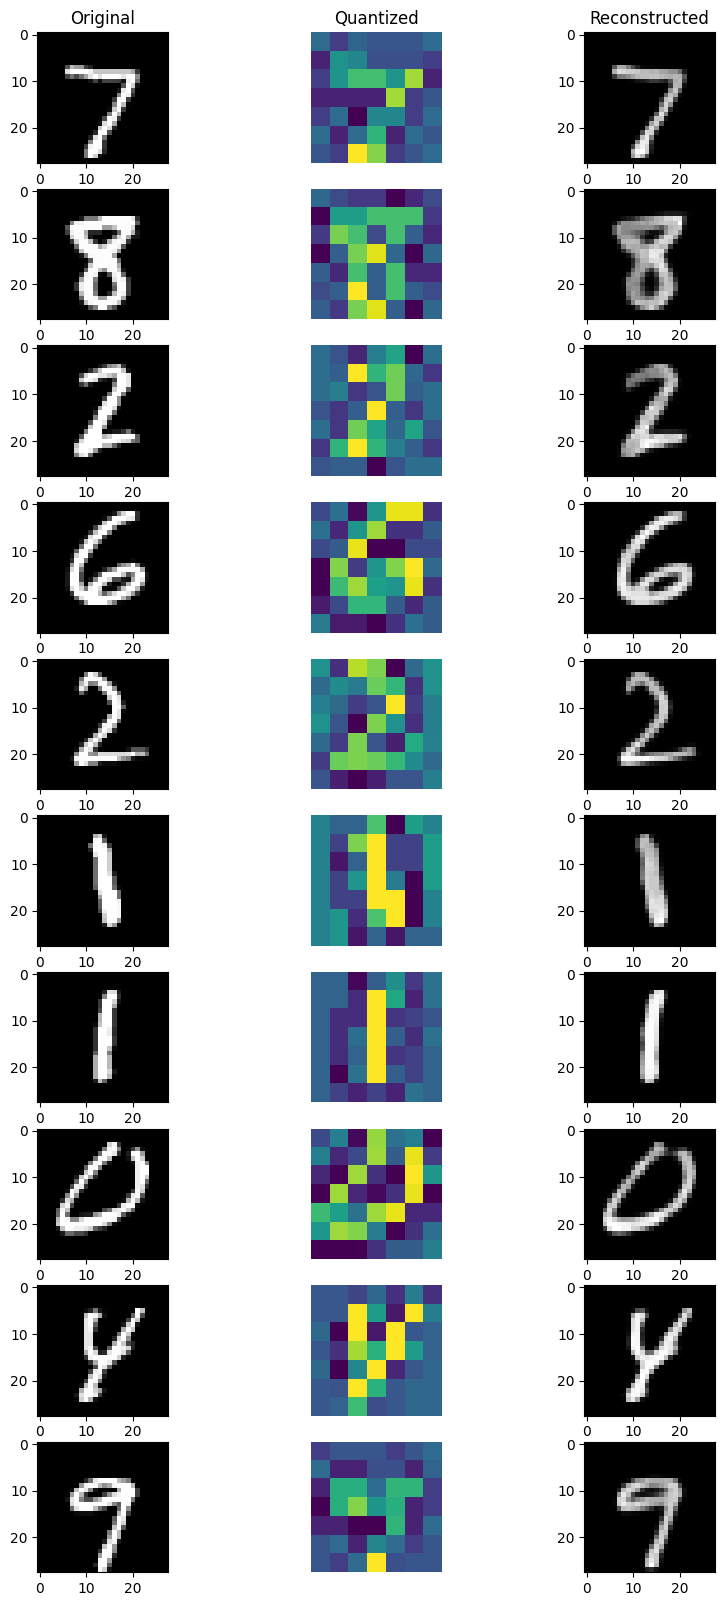

In [9]:
model = VectorQuantizedVAE(3, 30, 2, 0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

codebooks = train(model, train_loader, optimizer, num_epochs=10)
plot_samples(model, test_loader)
save_codebook_animation(codebooks, 'codebook_30.gif')

100%|██████████| 469/469 [00:17<00:00, 27.17it/s]


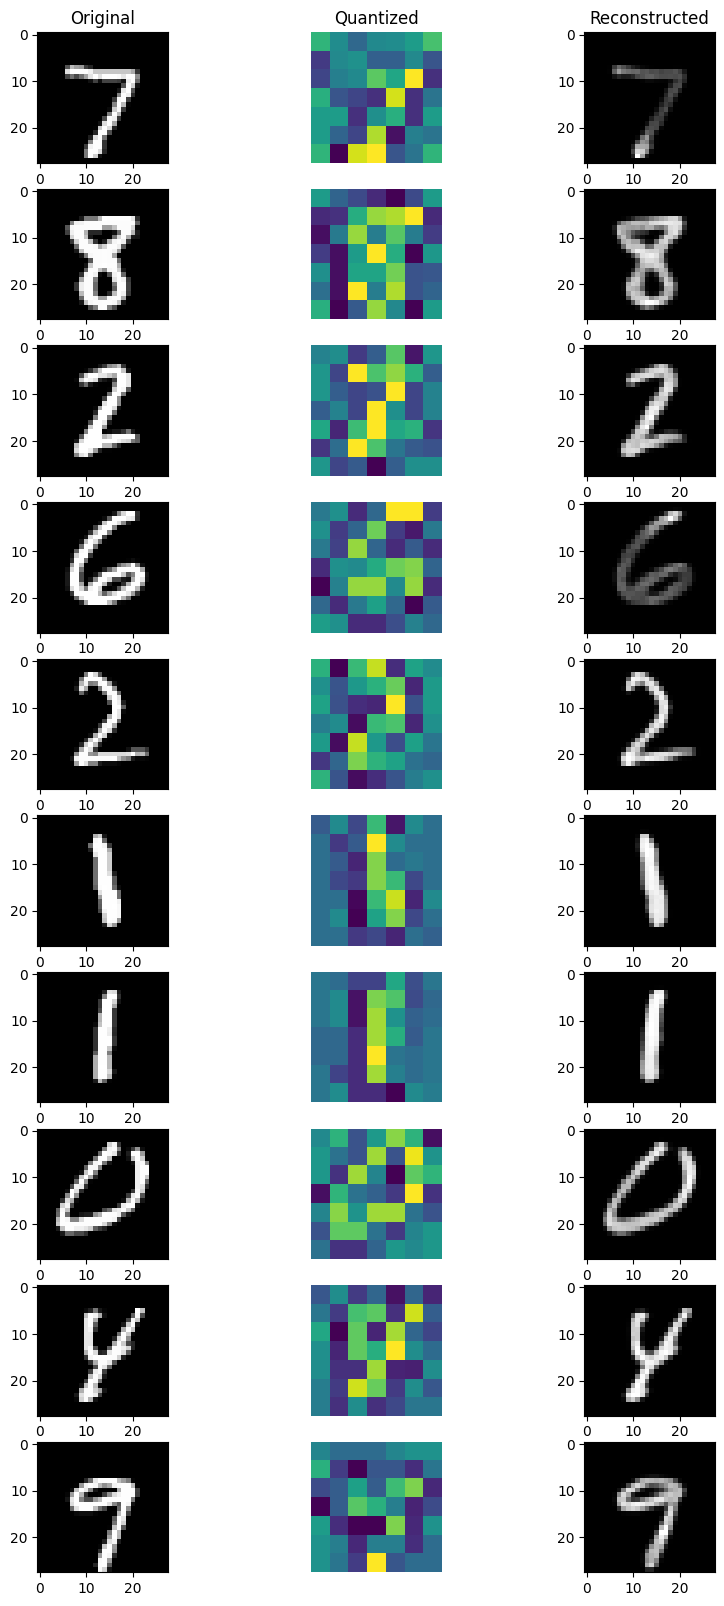

In [10]:
model = VectorQuantizedVAE(3, 50, 2, 0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

codebooks = train(model, train_loader, optimizer, num_epochs=10)
plot_samples(model, test_loader)
save_codebook_animation(codebooks, 'codebook_50.gif')

100%|██████████| 469/469 [00:16<00:00, 28.86it/s]


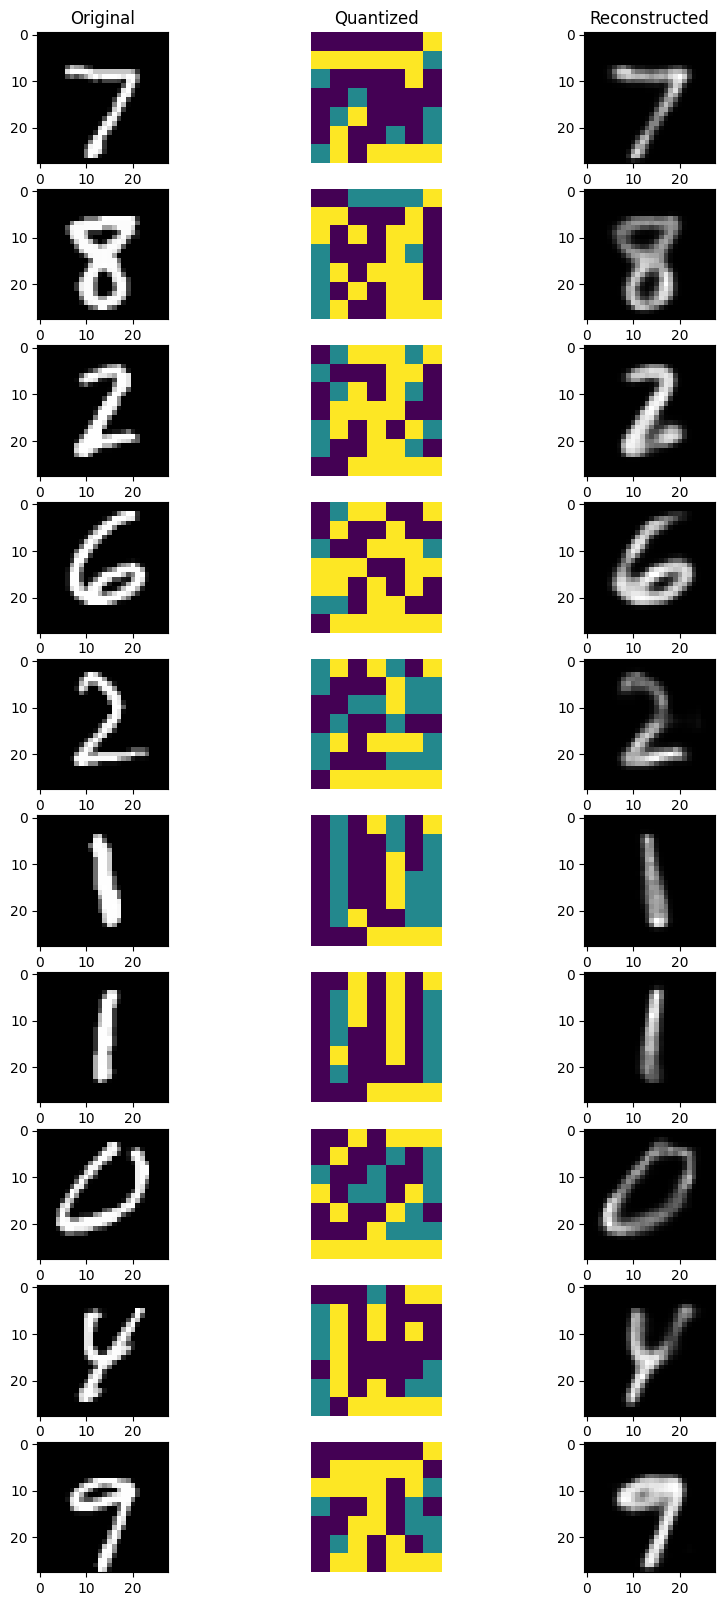

In [11]:
model = VectorQuantizedVAE(3, 3, 50, 0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

codebooks = train(model, train_loader, optimizer, num_epochs=10)
plot_samples(model, test_loader)
save_codebook_animation(codebooks, 'codebook_3_50d.gif')